# Importing the needed libraries

In [2]:
import os
import sys
import time
import argparse
import requests
import contextlib
from tqdm import tqdm
import tempfile
import h5py
import atexit
import numpy as np
import subprocess
#from illustris_python.groupcat import loadSingle, loadHeader
#import illustris_python as il
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl3
from numpy.linalg import eig
from numpy.linalg import eigh
from scipy.optimize import curve_fit, root
from scipy.spatial.transform import Rotation as R
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec

from multiprocessing import Pool, current_process
from itertools import product


G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun
headers = {"api-key": '81b7c70637fa8b110e6b9f236ea07c37'}
box_size = 75 * 1e3 / h # kpc
a = 1 # scale factor
z = 0 # Redshift

R_bins = np.geomspace(1, 100, 20)

In [3]:
def rotate(particles, velocities, theta = np.pi/2, rot_mat = None):
    '''
    Rotation in the y-axis

    Parameters
    ----------

    particles: np.array with shape (N,3) containing the coordinates of
        the particles that will be rotated.
        
    velocities: np.array with shape (N,3) containing the velocities of
        the particles that will be rotated.

    theta: float. Angle that will be rotated around y-axis. Default = np.pi/2

    rot_mat: (optional) Rotation matrix to be used. It can be any rotation matrix,
        no need to be around y-axis. Default = None

    Returns
    -------

    particles_rot:np.array shape (N,3) with the rotated coordinates.
    
    velocities_rot:np.array shape (N,3) with the rotated velocities.    
    '''
    
    if rot_mat is None:
        rot_mat = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
    particles_rot = particles @ rot_mat
    velocities_rot = velocities @ rot_mat
    return particles_rot, velocities_rot

In [4]:
stars_old_header = ' Stellar particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
stars_sb_header = ' Stellar particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: star formation rate (Msun/yr) \n Column 9: metallicity (1) \n Column 10: compactness (1) \n Column 11: pressure (K/m3) \n Column 12: cloud covering fraction (1) \n'
gas_header = ' Gas particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a medium source using M_dust = f_dust x Z x M_gas \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: gas mass volume density (Msun/pc3) \n Column 5: metallicity (1) \n Column 6: x-velocity (km/s) \n Column 7: y-velocity (km/s) \n Column 8: z-velocity (km/s) \n '

n_px     = 128 # Number of pixels
D        = 15 # Distance to galaxy [Mpc]
FoV      = 17.2 # Field of view [minutes]
px_s     = 17.2 / n_px # Pixel size [minutes] 
FoV_phys = FoV * (1/60) * (np.pi / 180) * D * 1e6 # physical distance at observer [Pc]
Rmax     = int(0.5 * n_px * D * 1e3 * px_s * 4.848e-6)
Rframe   = Rmax * 1e3 # [Pc]
Rmedium  = FoV_phys
Rgrid    = 0.5 * Rframe

In [5]:
import martini
from martini.sources import TNGSource, SPHSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel, find_fwhm
import astropy.units as U
from Hdecompose.atomic_frac import atomic_frac

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as U
import astropy.constants as C

In [6]:
#import illustris_python as il
import pts.simulation as sm
import pts.utils as ut
import pts.visual as vis
import pts.band as bd
import pts.do

In [7]:
SDSS_U = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_U_BroadBand.stab')
SDSS_G = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_G_BroadBand.stab')
SDSS_R = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_R_BroadBand.stab')
SDSS_I = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_I_BroadBand.stab')
SDSS_Z = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_Z_BroadBand.stab')

In [8]:
# This rotation is to have the same "sky plane" in martini than in skirt
theta = np.pi/2
# We have to perform this rotation to have the same sky plane in both codes
rot_mat_martini = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
                ])

beam = GaussianBeam(
    bmaj = 30.0 * U.arcsec, bmin=30.0 * U.arcsec, bpa=0.0 * U.deg, truncate=3.0
)

noise = GaussianNoise(
    rms = 3.0e-8 * U.Jy * U.beam**-1
)

spectral_model = GaussianSpectrum(sigma = "thermal")

sph_kernel = CubicSplineKernel()

# Some custom functions

In [9]:
def getConvolvedRGBArray(simulation, contributions, name="", *, fileType="total"):
    """
    Obtiene el array RGB con unidades físicas (MJy/sr) de los datos de SKIRT
    sin aplicar transformaciones de visualización.
    
    Parameters
    ----------
    simulation : SKIRT simulation object
    contributions : list
        Lista de tuplas (band, r, g, b) con los filtros y sus contribuciones
    name : str, opcional
        Nombre identificador
    fileType : str, opcional
        Tipo de archivo (default: "total")
        
    Returns
    -------
    astropy.units.Quantity
        Array RGB con unidades de MJy/sr
    """
    # Obtener los paths de los archivos
    instr_paths = sm.instrumentOutFilePaths(simulation, fileType+".fits")
    
    if len(instr_paths) > 0:
        sbunit = sm.unit("MJy/sr")
        
        # Tomamos el primer instrumento/archivo
        instrument, filepath = instr_paths[0]
        
        # Obtener el cubo de datos en sus unidades intrínsecas
        cube = sm.loadFits(filepath)
        
        # Inicializar el frame RGB
        dataRGB = np.zeros((cube.shape[0], cube.shape[1], 3)) << sbunit
        
        # Agregar color para cada filtro
        for band, w0, w1, w2 in contributions:
            # Convolucionar y convertir a unidades por frecuencia
            data = band.convolve(instrument.wavelengths(), cube, flavor=sbunit)
            dataRGB[:,:,0] += w0*data
            dataRGB[:,:,1] += w1*data
            dataRGB[:,:,2] += w2*data
            
        return dataRGB
    
    return None



In [10]:
def get(path, params=None, folderName=''):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        if filename.endswith('.hdf5'):
            file_access_property_list = h5py.h5p.create(h5py.h5p.FILE_ACCESS)
            file_access_property_list.set_fapl_core(backing_store=False)
            file_access_property_list.set_file_image(r.content)
            
            file_id_args = {
                'fapl': file_access_property_list,
                'flags': h5py.h5f.ACC_RDONLY,
                'name': next(tempfile._get_candidate_names()).encode()
            }
            
            h5_file_args = {'backing_store': False, 'driver': 'core', 'mode': 'r'}
            with contextlib.closing(h5py.h5f.open(**file_id_args)) as file_id:
                with h5py.File(file_id, **h5_file_args) as h5_file:
                    #return np.array(h5_file['grid'])
                    if 'grid' in h5_file.keys(): return np.array(h5_file['grid'])
                    else:
                        results = []
                        for k in h5_file.keys():
                            for sk in h5_file[k].keys():
                                results.append(np.array(h5_file[k][sk]))
                        return results
        else:
            with open(folderName + filename, 'wb') as f:
                f.write(r.content)
            return filename # return the filename string
    return r


In [11]:
def get1(path, name, params=None):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    headers = {"api-key":"81b7c70637fa8b110e6b9f236ea07c37"}
    r = requests.get(path, params=params, headers=headers)
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(name + '.hdf5', 'wb') as f:
            f.write(r.content)
        return name + '.hdf5' # return the filename string
    return NULL

In [12]:
def compute_mass_profile(gid, center):
    '''
    MIHAEL FUNCTION: compute the dark matter mass enclosed in 20 radii
    from 1 to 100 kPc
    
    Parameters
    ----------
    gid : int 
        GroupID
    center : list
        (x,y,z) Position of the group
    
    Returns
    -------
    
    NP Array
        Array with the dark matter mass enclosed in 20 radii from 1 to 100 kPc
    '''
    dm = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates'])
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    center = np.where(center > 32500, center - 75000, center)
    center = np.where(center < -32500, center + 75000, center)
    dm = dm - center
    dist = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        if D < 100: dist.append(D)
    R_bins = np.geomspace(1, 100, 20)
    M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
    return M

In [13]:
def compute_total_mass_profile(Rmax, Rmin, Nm, sub_meta, url):
    '''
    Computes the dark matter, stars and gas mass enclosed in Nm radii
    from Rmin to Rmax kPc
    
    Parameters
    ----------
    Rmin, Rmax : float 
        Min and Max radii
    Nm : int
        Number of radial bins
    sub_meta : str
        Illustris information of the subhalo
    url : str
        Url to the Illustris server
    
    Returns
    -------
    
    List
        List of 4 Arrays corresponding to the radial bins and the 
        dark matter, stars and gas mass enclosed in Nm radii from 
        Rmin to Rmax kPc
    '''
    center = np.array([sub_meta['pos_x'], sub_meta['pos_y'], sub_meta['pos_z']])
    particles  = get(url + 'cutout.hdf5', {'dm':'Coordinates',
                                                'gas':'Coordinates,Masses',
                                                'stars':'Coordinates,Masses'
                                               })
    
    dm = particles[2] - center
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    
    dist_dm = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_dm.append(D)
    
    m_gas = particles[1] * 1e10/h
    gas = particles[0] - center
    gas = np.where(gas > 32500, gas - 75000, gas)
    gas = np.where(gas < -32500, gas + 75000, gas)
    
    dist_gas = []
    for d in gas:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_gas.append(D)

    m_stars = particles[4] * 1e10/h
    stars = particles[3] - center
    stars = np.where(stars > 32500, stars - 75000, stars)
    stars = np.where(stars < -32500, stars + 75000, stars)
    
    dist_stars = []
    for d in stars:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_stars.append(D)
            
    R_bins = np.geomspace(Rmin, Rmax, Nm)
    
    p_dm    = np.array([len(np.where(np.array(dist_dm) < R)[0]) * M_dm for R in R_bins])
    p_stars = np.array([sum(m_stars[np.where(np.array(dist_stars) < R)[0]]) for R in R_bins])
    p_gas   = np.array([sum(m_gas[np.where(np.array(dist_gas) < R)[0]]) for R in R_bins])
    return R_bins, p_dm, p_stars, p_gas

In [14]:
def compute_rot_mat_inertia(subhalo_pos, coordinates, masses, Rmin=0, Rmax=20):
    '''
    MIHAEL FUNCTION: computes the intertia momenta of a subhalo with ID sid
    
    Parameters
    ----------
    
    
    Returns
    -------
    
    Matrix
        Rotation matrix for align the intertia momenta with the z-axis
    '''
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    coordinates = np.delete(coordinates, indices, axis=0)
    masses = np.delete(masses, indices)
    
    I = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i == j: I[i][j] = np.sum(masses * (distances**2 - coordinates[:,i] * coordinates[:,j]))
            else: I[i][j] = np.sum(masses * (- coordinates[:,i] * coordinates[:,j]))
    
    I_eign = np.linalg.eigh(I)
    L = I_eign[1][2]
    #print(I)
    #print(L / np.linalg.norm(L))
    
    rot, _ = R.align_vectors([L, np.cross(L, [1,0,0])], [[0,0,1],[0,1,0]])
    return rot.as_matrix(), L



In [15]:
def compute_rot_mat_angMom(subhalo_pos, coordinates, velocities, masses, Rmin = 0, Rmax = 20):
    '''
    Compute the angular momenta and return a rotation matrix that align the angular
        momenta with the z-axis

    Parameters
    ----------

    subhalo_pos: np.array with shape (1,3) containing the position of the subhalo. 
        This will be used to center the particles.

    coordinates: np.array with shape (N,3) containing the coordinates of
        the particles that will be analysed.
        
    velocities: np.array with shape (N,3) containing the velocities of
        the particles that will be analysed.
        
    masses: np.array with shape (N) containing the masses of the particles that will be analysed.

    Rmin:  float. Particles at a distance to the subhalo below Rmin will not be considered for
        the computation of the angular momenta.
        
    Rmax:  float. Particles at a distance to the subhalo above Rmax will not be considered for
        the computation of the angular momenta.

    Returns
    -------

    np.array shape (3,3) with the rotation matrix needed for align the angular momenta
        with the z-axis.
    
    np.array shape (3) wiht the angular momenta vector in the original coordinates.    
    '''
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    
    coordinates = np.delete(coordinates, indices, axis = 0)
    masses = np.delete(masses, indices)
    velocities = np.delete(velocities, indices, axis = 0)
    
    L = (np.cross(coordinates, velocities).T * np.array(masses)).T
    Lmean = np.mean(L, axis=0)
    #print(Lmean / np.linalg.norm(Lmean))
    
    rot, _ = R.align_vectors([Lmean, np.cross(Lmean, [1,0,0])], [[0,0,1],[1,0,0]])
    return rot.as_matrix(), Lmean

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

# Looking for the subhalos

In [17]:
N     = 40000 # Number of samples.

Mmin  = 1e10 # Minimum total mass.
Mmax  = 1e13 # Maximum total mass.
Mdmin = 1e9 # Minimum dark matter mass in half radius.
Mdmax = 1e13 # Maximum dark matter mass in half radius.
Mgmin = 1e8 # Minimum gas mass.
Mgmax = 1e13 # Maximum gas mass.
Msmin = 1e10 # Minimum stellar mass.
Msmax = 1e12 # Maximum stellar mass.

sim   = 'TNG100-1' # Name of simulation run.
z     = 99  # Snapshot number.
myBasePath = '../sims.TNG/' + sim +'/output/'

mass_min      = (Mmin * h) * 1e-10 # Minimum total mass
mass_max      = (Mmax * h) * 1e-10 # Maximum total mass
dm_mass_min   = (Mdmin * h) * 1e-10 # Minimum total dm mass
dm_mass_max   = (Mdmax * h) * 1e-10 # Maximum total dm mass
gas_mass_min  = (Mgmin * h) * 1e-10 # Minimum total gas mass
gas_mass_max  = (Mgmax * h) * 1e-10 # Maximum total gas mass
star_mass_min = (Msmin * h) * 1e-10 # Minimum total star mass
star_mass_max = (Msmax * h) * 1e-10 # Maximum total star mass


subhalos_url = 'http://www.tng-project.org/api/' + sim + '/snapshots/' + str(z) + '/subhalos'
url          = subhalos_url
subhalos     = get(subhalos_url, {'limit': N, 'offset': 0,
                                #'mass__gt': mass_min, 'mass__lt': mass_max,                                     
                                #'massinhalfrad_dm__gt':dm_mass_min,'massinhalfrad_dm__lt':dm_mass_max, 
                                #'mass_gas__gt': gas_mass_min, #'mass_gas__lt': gas_mass_max,
                                'mass_stars__gt': star_mass_min,# 'mass_stars__lt': star_mass_max,
                                'filterFlag': True, 'parent__lt':1, 
                                'sfr__gt':0.1,
                                'subhaloflag__gt':0})

nsubhalos = len(subhalos['results'])

In [18]:
nsubhalos

4071

# Analyzing each individual subhalo (ie galaxy)

In [17]:
!pwd

/u/m/mdelosri/MaDaMe/codes


In [18]:
file = '../data/gals_properties.h5'
data = h5py.File(file, 'a')

In [24]:
list(data.keys())

['MainProps', 'SubID_0']

In [25]:
try:
    flag_MainProps = True
    old_MainProps = data['MainProps'][()]
except:
    flag_MainProps = False

In [40]:
#itialization of properties 
save_part_halo = True
save_part_subhalo = True

nsubhalos = 50
properties = np.zeros((nsubhalos, 17))

rmax = 1000 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

#i = 2
for i in tqdm(range(nsubhalos)):
    print(data.keys())
    ids = subhalos['results'][i]['id']
    # Let's load the data of the subhalos
    sub_meta = get(subhalos['results'][i]['url'])    
    # --------------------------------------------------------
    if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
        else:
            gr = data.create_group('SubID_' + str(ids))
            flag_gr = True # This means that we have to analyze the group
            gr.attrs['done'] = False
    
        if flag_gr:
            # Let's save the main properties  ------------------------           
            properties[i, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[i, 1] = gid
            properties[i, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[i, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[i, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[i, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[i, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[i, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[i, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[i, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[i, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[i, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[i, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[i, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
    
            gr.create_dataset('Props', data = properties[i,:])
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[i, 5:8]
            velocity     = properties[i, 8:11]
    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                #gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                #                   {'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_c, axis=1)
            #for d in dm_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[i, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            #for d in stars_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                #for d in gas_c:
                #    D = np.sqrt(sum([c**2 for c in d]))
                #    if D < 100: dist.append(D)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's save the particles
            if save_part_subhalo:
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', stars_c[ind_stars])
                #np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', aux_subhalo[0])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsInitMass.txt', stars_subhalo[1][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMetal.txt', stars_subhalo[2][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsSFT.txt', stars_subhalo[3][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMasses.txt', stars_m[ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsHsml.txt', stars_subhalo[5][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsVels.txt', stars_v[ind_stars])
                if flag_gas:
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasCoord.txt', gas_c[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasDens.txt', gas_subhalo[1][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_eAbund.txt', gas_subhalo[2][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMetal.txt', gas_subhalo[3][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHI.txt', gas_HI[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_intEne.txt', gas_subhalo[5][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMasses.txt', gas_m[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHsml.txt', gas_subhalo[7][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasVels.txt', gas_v[ind_gas])
            # ----------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[i, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[i, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[i, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[i, 15] = kappa_stars_AM
            properties[i, 16] = kappa_stars_IT
            # --------------------------------------------------------
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            #dm_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates']) / h
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_halo, axis=1)
            #for d in dm_halo:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            #stars_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Coordinates']) / h
            #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Masses']) * 1e10 / h
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            #for d in stars_halo_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
                           #{'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
            #gas_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Coordinates']) / h
            #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Masses']) * 1e10 / h
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            #for d in gas_halo_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
    # ---------------------------------------------------------------------------------------
    #except:
    #    pass
            if save_part_halo:
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsCoord.txt', stars_halo_c[ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsInitMass.txt', stars_halo[1][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMetal.txt', stars_halo[2][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsSFT.txt', stars_halo[3][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMasses.txt', stars_halo_m[ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsHsml.txt', stars_halo[5][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsVels.txt', stars_halo_v[ind_stars])
                if flag_gas:
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasCoord.txt', gas_halo_c[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasDens.txt', gas_halo[1][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_eAbund.txt', gas_halo[2][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMetal.txt', gas_halo[3][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHI.txt', gas_halo_HI[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_intEne.txt', gas_halo[5][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMasses.txt', gas_halo_m[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHsml.txt', gas_halo[7][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasVels.txt', gas_halo_v[ind_gas])
    
            # Let's save a flag indicating that everything was done
            gr.attrs['done'] = True
        
    # Let's delete from the properties dataset the rows with no info
            if (i % 10) == 0:
                # After 10 subhalos let's save the data and start again
                properties = np.delete(properties, np.where(properties[:,2] == 0)[0], axis = 0)
    
                if len(properties[:,0] > 0):
                    if flag_MainProps:
                        properties = np.vstack((old_MainProps, properties))
                        del data['MainProps']
                        data.create_dataset('MainProps', data = properties)
                    else:
                        data.create_dataset('MainProps', data = properties)
                data.close()
                data = h5py.File(file, 'a')
                try:
                    flag_MainProps = True
                    old_MainProps = data['MainProps'][()]
                except:
                    flag_MainProps = False
                properties = np.zeros((nsubhalos, 17))

  0%|          | 0/50 [00:00<?, ?it/s]

<KeysViewHDF5 ['SubID_400547']>


  0%|          | 0/50 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Full pipe-line

In [ ]:
!pwd

In [29]:
tmp_folder = '../data/tmp/'

In [36]:
distances = [4, 10, 20]
rotations = [0, np.pi/6, np.pi/2]
nrot  = len(rotations)
ndist = len(distances)

In [37]:
force_rerun = False
make_png = True

file = '../data/gals_properties.h5'

nsubhalos = 200
properties = np.zeros((1, 17))

rmax = 1000 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

nmax = 1
ni = 0
with h5py.File(file, 'a') as data:
    for i in tqdm(range(106,nsubhalos)):
        ids = subhalos['results'][i]['id']
        
        # Let's load the data of the subhalos
        sub_meta = get(subhalos['results'][i]['url'])    
        # --------------------------------------------------------
    
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
            if force_rerun:
                flag_gr = True
                print('Analysis forced to be run again!')
        else:
            if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies           
                gr = data.create_group('SubID_' + str(ids))
                flag_gr = True # This means that we have to analyze the group
                gr.attrs['done'] = False
            else:
                flag_gr = False # This means that we do not have to analyze the group
        
        if flag_gr:
            start = time.time()
            folder = '../data/TNGgalaxies/' + str(ids)
            if not os.path.exists(folder):
                os.makedirs(folder)
            
            # Let's save the main properties  ------------------------           
            properties[0, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[0, 1] = gid
            properties[0, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[0, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[0, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[0, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[0, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[0, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[0, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[0, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[0, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[0, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[0, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[0, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[0, 5:8]
            velocity     = properties[0, 8:11]    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_c, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[0, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[0, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[0, 15] = kappa_stars_AM
            properties[0, 16] = kappa_stars_IT
            # --------------------------------------------------------
            gr.create_dataset('Props', data = properties[0,:])
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_halo, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
            # -------------------------------------------------------------------------------------
    
            # Let's read the particles and perform the corresponding rotations
            stars_particles = stars_halo_c[ind_stars] # [kPc]
            npart = len(stars_particles)
            
            aux = stars_halo[5][ind_stars] / h # Hsml [kPc]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo_v[ind_stars] # Vels [km sqrt(a)/s]
            stars_particles = np.hstack((stars_particles, aux))
            
            aux = stars_halo[1][ind_stars] * (1e10) / h # [Msun]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo[2][ind_stars]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            stars_SFT = stars_halo[3][ind_stars]
            
            stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6
            
            stars_particles = np.hstack((stars_particles, stars_t0.reshape(npart, 1)))
    
            # Discard wind particles (definition from illustris documentation) 
            ind_wind = np.where(stars_SFT <= 0)[0]
            if len(ind_wind) > 0:
                stars_particles = np.delete(stars_particles, ind_wind, axis=0)
                
            # Compute the rotation matrix to alig the ang momenta to the z-axis
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_particles[:,0:3], stars_particles[:,4:7], stars_particles[:,8], Rmax = 200)
            
            # Separare old from young stars:
            ind_old = np.where(stars_particles[:,9] > 1e-2)[0]        # from where do we get this condition???
            ind_new = np.where(stars_particles[:,9] <= 1e-2)[0]

            # Gas partciles
                        
            gas_particles = gas_halo_c[ind_gas] # [kPc]
            gas_npart = len(gas_particles)
            
            aux = gas_halo[1][ind_gas] * (1e10) * (h**2) # [Msun / kPc^3]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo[3][ind_gas]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo_v[ind_gas] # Vels [km sqrt(a)/s]
            gas_particles = np.hstack((gas_particles, aux))

            if 'thetas' in gr.attrs: 
                thetas = gr.attrs['thetas']
            else:
                thetas = []
            
            if 'dists' in gr.attrs: 
                dists = gr.attrs['dists']
            else:
                dists = []
            
            if 'names' in gr.attrs: 
                names = gr.attrs['names']
            else:
                names = []
                
            for idist in range(ndist):
                D = distances[idist]
                for irot in range(nrot):       
                    theta = rotations[irot]
                    print('Distance = {:.2e} Theta = {:.2f}'.format(D, theta))
                    
                    particles = np.copy(stars_particles)
                    # Rotate to be edge-on: (SKIRT is observing from z axis, i.e, it observe the plane x-y) 
                    particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                                theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
                    particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                                theta = theta) # This put the AM in the x-axis to be edge-on on skirt
                            
                    particles_old = particles[ind_old]
                    particles_new = particles[ind_new]
                    
                    if len(ind_old) > 0:
                        np.savetxt(tmp_folder + '/stars_old.txt', particles_old, header = stars_old_header)
                        
                    if len(ind_new) > 0:
                        log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
                        P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
                        ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
                        particles_new[:,7] = particles_new[:,7] / particles_new[:,9] * 1e9 # I dont know why we do this
                        
                        particles_new = np.hstack((particles_new, log10C, P, ccf))
                    
                        np.savetxt(tmp_folder + '/stars_sb.txt', particles_new, header = stars_sb_header)

                    
                    # Rotate gas data to be edge-on
                    particles = np.copy(gas_particles)
                    
                    particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                                theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
                    particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                                theta = theta) # This put the AM in the x-axis (to be edge-on in skirt)
                    
                    # Let's save the data
                    particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
                    np.savetxt(tmp_folder + '/gas.txt', particles, header = gas_header)
                    # ----------------------------------------------------------------
            
                    # Let's start with SKIRT
                    skifile = sm.SkiFile('template.ski')
                    #skifile.setStringAttribute('.//ParticleSource', 'filename', '../../stars_old.txt')
                    #skifile.setStringAttribute('.//VoronoiMeshMedium', 'filename', '../../gas.txt')
                    
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')
            
                    skifile.setNumPrimaryPackets(2e7)
                    skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
                    skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
                    skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
                    skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(100000) + ' pc')
                    skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(100000) + ' pc')
                    
                    skifile.saveTo(tmp_folder + '/galaxy.ski')
            
                    skirt = sm.Skirt()
                    simulation = skirt.execute(tmp_folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief

                    if make_png:
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)        
            
                        name_old = folder +  "/galaxy_cube_total_SDSS_U.png "
                        name_new = folder +  '/SDSS_U_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_G.png "
                        name_new = folder +  '/SDSS_G_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_R.png "
                        name_new = folder +  '/SDSS_R_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_I.png "
                        name_new = folder +  '/SDSS_I_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_Z.png "
                        name_new = folder +  '/SDSS_Z_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)

                    name_old = folder +  "/galaxy_cube_total.fits "
                    name_new = folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
                    subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
                    subprocess.run("rm "  + folder + "/galaxy_*.fits ", shell=True, text=True, capture_output=True)
                    # -----------------------------------------------------------------------
            
                    # Let's use MARTINI
                    
                    xe_g  = gas_halo[2][ind_gas]
                    rho_g = gas_halo[1][ind_gas] * (1e10) * (h**2) * U.Msun * np.power(U.kpc, -3)
                    u_g   = gas_halo[5][ind_gas] # [km/s^2]  # unit conversion handled in T_g
                    X_H_g = gas_halo_HI[ind_gas] # GFM_Metals[:,0] HI
                    mu_g  = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
                    gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
                    T_g   = ((gamma - 1) * u_g / C.k_B.to_value(U.erg / U.K) * 1e10 * mu_g * U.K * C.m_p.to_value(U.g))
                    m_g   = gas_halo_m[ind_gas] * U.Msun # Msun                    
                    nH_g  = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p # cast to float64 to avoid underflow error (from martini)
                                # In TNG_corrections I set f_neutral = 1 for particles with density
                                # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
                                # tables for TNG will be available soon anyway.
                    fatomic_g = atomic_frac(0, nH_g, T_g, rho_g, X_H_g, mu=mu_g, onlyA1=True, TNG_corrections=True)
                    mHI_g  = m_g * X_H_g * fatomic_g        
                    xyz_g  = particles[:,0:3] * U.kpc
                    vxyz_g = particles[:,5:8] * U.km / U.s
                    V_cell = (m_g / rho_g)  # Voronoi cell volume
                    r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
                    # hsm_g has in mind a cubic spline that =0 at r=h, I think (from martini)
                    hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)
            
                    source = SPHSource(
                        distance = D * U.Mpc,
                        h        = h,
                        T_g      = T_g,
                        mHI_g    = mHI_g,
                        xyz_g    = xyz_g,
                        vxyz_g   = vxyz_g,
                        hsm_g    = hsm_g,
                        rotation = {"rotmat": rot_mat_martini} # This rotation need to be done because martini observer is on x axis
                    )
            
                    datacube = DataCube(
                        n_px_x     = 384,
                        n_px_y     = 384,
                        n_channels = 50,
                        px_size    = 10.0 * U.arcsec,
                        channel_width   = 16.0 * U.km * U.s**-1,
                        velocity_centre = source.vsys,
                        ra  = source.ra,
                        dec = source.dec,
                    )
            
                    M = Martini(source = source, datacube = datacube, beam = beam,
                        noise = noise, spectral_model = spectral_model, sph_kernel = sph_kernel)
            
                    M.insert_source_in_cube(ncpu=1)
                    M.add_noise()
                    M.convolve_beam()
                    M.write_fits(tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta))

                    if make_png:
                        with fits.open(tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)) as f:
                            cube_wcs   = WCS(f[0].header)
                            flux_cube  = f[0].data * U.Unit(f[0].header["BUNIT"])
                            n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
                            vch        = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
                                0
                            ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
                            vch = vch - source.vsys
                
                        # choose plotting units
                        mom0_unit = U.Jy / U.beam
                        mom1_unit = U.km / U.s
                        mom2_unit = U.km / U.s
                        
                        rms  = np.std(flux_cube[:, :16, :16])  # noise in a corner patch where there is little signal
                        clip = np.where(flux_cube > 5 * rms, 1, 0)
                        np.seterr(all="ignore")
                
                        mom0 = np.sum(flux_cube, axis=0)
                        plt.imshow(mom0.to_value(mom0_unit), cmap="Greys")
                        plt.savefig(tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                
                        mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
                        mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
                        plt.imshow(
                            (mom1 * mask).to_value(mom1_unit),
                            cmap = "RdBu_r",
                            vmin = -np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                            vmax = np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                        )
                        plt.savefig(tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                
                        mom2 = np.sqrt(
                            np.sum(
                                flux_cube
                                * clip
                                * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
                                axis=0,
                            )
                            / mom0
                        )
                        plt.imshow((mom2 * mask).to_value(mom2_unit),cmap="magma")        
                        plt.savefig(tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                        #------------------------------------------------------------------------
                
                    # Move the images and remove the data
                    subprocess.run("mv ../data/tmp/*.png " + folder, shell=True, text=True, capture_output=True)
                    subprocess.run("mv ../data/tmp/*SubID_{}*.fits ".format(ids) + folder, shell=True, text=True, capture_output=True)
                    subprocess.run("rm ../data/tmp/*.* ", shell=True, text=True, capture_output=True)
                    #-------------------------------------------------------------------------

                    thetas.append(theta)
                    dists.append(D)
                    names.append('d_{:.1f}_theta_{:.2f}'.format(D, theta))
            
            gr.attrs['thetas'] = thetas
            gr.attrs['dists'] = dists
            gr.attrs['names'] = names
            # Let's save a flag indicating that everything was done
            gr.attrs['done'] = True
            stop = time.time()
            print('Subhalo {} analyzed in {:.2f} hours'.format(ids, (stop-start) / 3600))
            ni += 1
            if ni == nmax: break
            
            

 11%|█         | 10/94 [00:14<01:48,  1.29s/it]

Starting the estimation of properties with subhalo particles for galaxy 114388
Starting the estimation of properties with halo particles for galaxy 114388


/tmp/ipykernel_542708/2238376362.py:464: RuntimeWarning: invalid value encountered in power
  stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6


Distance = 4.00e+00 Theta = 0.00
02/12/2024 14:34:13.298   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
02/12/2024 14:34:13.298   Running on coglians.phys.sissa.it for mdelosri
02/12/2024 14:34:13.299   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp/galaxy.ski'...
02/12/2024 14:36:48.457 - Finished setup in 155 s (2m 35s).
02/12/2024 14:36:48.457 - Finished setup output in 0.0 s.
02/12/2024 14:38:50.886 - Finished primary emission in 122 s (2m 2s).
02/12/2024 14:38:57.923 - Finished secondary emission in 7.0 s.
02/12/2024 14:38:57.923 - Finished the run in 129 s (2m 9s).
02/12/2024 14:39:02.460 - Finished final output in 4.5 s.
02/12/2024 14:39:02.460 - Finished simulation galaxy using 4 threads and a single process in 289 s (4m 49s).
02/12/2024 14:39:02.678   Available memory: 125 GB -- Peak memory usage: 7.08 GB (5.6%)
Source module contained 4249442 particles with total HI mass of 1.19e+11 solMass.
Pruned particles that will not contrib

100%|██████████| 163216/163216 [16:33<00:00, 164.37it/s]


Source inserted.
  Flux density in cube: 7.24e+02 Jy
  Mass in cube (assuming distance 4.00 Mpc and a spatially resolved source): 4.37e+10 solMass
    [37% of initial source mass]
  Maximum pixel: 9.43e-05 Jy / arcsec2
  Median non-zero pixel: 8.99e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 3.96e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 4.09e-03 Jy / beam
  Maximum pixel: 8.69e-02 Jy / beam
  Median non-zero pixel: 5.34e-08 Jy / beam


 11%|█         | 10/94 [24:26<3:25:18, 146.64s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../data/tmp/HIEmission_SubID_114388__d_4.0_theta_0.00.fits'

# Trying to make it parallel

In [45]:
def analyze_subhalo(combinaciones):
    '''
    Function that analyze a given subhalo and produce the SKIRT and MARTINI images.
    The photometrical images are convolved with SDSS filter and are saved as np arrays.
    The MARTINI images are also saved as np arrays.

    Parameters
    ----------

    combinaciones: list of tuples. The first element of each tuple correspond
        to the distance at which the galaxy is "observed", while the second 
        element correspond to the angle with respect to the line-of-sight.

    Returns
    -------

    D: Distance at which the galaxy is "observed".
    theta: Angle with respect to the line-of-sight
    flag: 0 means that something wnet wrong and the images were not produced,
          1 means that everything went right.
    '''
    flag = 0
        
    theta = combinaciones[1]
    D = combinaciones[0]
    try:
        tmp_folder = 'tmp_' + str(current_process().name) + '/'
        os.makedirs('../data/' + tmp_folder)
        particles = np.copy(stars_particles)
        # Rotate to be edge-on: (SKIRT is observing from z axis, i.e, it observe the plane x-y) 
        particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                    theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
        particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                    theta = theta) # This put the AM in the x-axis to be edge-on on skirt
                
        particles_old = particles[ind_old]
        particles_new = particles[ind_new]
        
        if len(ind_old) > 0:
            np.savetxt('../data/' + tmp_folder + '/stars_old.txt', particles_old, header = stars_old_header)
            
        if len(ind_new) > 0:
            log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
            P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
            ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
            particles_new[:,7] = particles_new[:,7] / particles_new[:,9] * 1e9 # I dont know why we do this
            
            particles_new = np.hstack((particles_new, log10C, P, ccf))
        
            np.savetxt('../data/' + tmp_folder + '/stars_sb.txt', particles_new, header = stars_sb_header)
    
        
        # Rotate gas data to be edge-on
        particles = np.copy(gas_particles)
        
        particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                    theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
        particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                    theta = theta) # This put the AM in the x-axis (to be edge-on in skirt)
        
        # Let's save the data
        particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
        np.savetxt('../data/' + tmp_folder + '/gas.txt', particles, header = gas_header)
        # ----------------------------------------------------------------
    
        # Let's start with SKIRT
        skifile = sm.SkiFile('template.ski')  
        
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')
    
        skifile.setNumPrimaryPackets(2e7)
        skifile.setStringAttribute('.//FrameInstrument', 'instrumentName', 'D_{:.1f}_theta_{:.2f}'.format(D, theta))
        skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
        skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
        skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
        skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(100000) + ' pc')
        skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(100000) + ' pc')
        
        skifile.saveTo('../data/' + tmp_folder + '/galaxy.ski')
        subprocess.run("sed -i 's|stars_old|../../" + tmp_folder + "stars_old|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
    
        subprocess.run("sed -i 's|stars_sb|../../" + tmp_folder + "stars_sb|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
        
        subprocess.run("sed -i 's|gas.txt|../../" + tmp_folder + "gas.txt|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
        
        #subprocess.run("sed -i 's|dist|" + str(D) + "|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
    
        skirt = sm.Skirt()
        simulation = skirt.execute('../data/' + tmp_folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief
    
        if make_png:
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)        
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_U.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_U_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_G.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_G_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_R.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_R_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_I.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_I_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_Z.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_Z_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
            U_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_U, 1., 0, 0],[SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]],name='SDSS_U')
            G_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_G, 1., 0, 0],[SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]],name='SDSS_G')
            R_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_R, 1., 0, 0],[SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]],name='SDSS_R')
            I_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_I, 1., 0, 0],[SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]],name='SDSS_I')
            Z_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_Z, 1., 0, 0],[SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]],name='SDSS_Z')
        
            # Guardar el array con sus unidades
            np.save(folder + '/SDSS_U_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), U_array.value[:,:,0])
            np.save(folder + '/SDSS_G_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), G_array.value[:,:,0])
            np.save(folder + '/SDSS_R_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), R_array.value[:,:,0])
            np.save(folder + '/SDSS_I_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), I_array.value[:,:,0])
            np.save(folder + '/SDSS_Z_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), Z_array.value[:,:,0])
    
            #%np.savetxt(folder + '/SDSS_U_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), U_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_G_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), G_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_R_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), R_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_I_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), I_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_Z_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), Z_array.value[:,:,0], fmt="%.3f")
    
        subprocess.run("mv ../data/" + tmp_folder + "*.png " + folder, shell=True, text=True, capture_output=True)
        
        name_old = '../data/' + tmp_folder +  "/galaxy_cube_total.fits "
        name_new = '../data/' + tmp_folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
        name_old = folder +  "/galaxy_cube_total.fits "
        name_new = folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*primary*.fits ", shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*secondary*.fits ", shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*transparent*.fits ", shell=True, text=True, capture_output=True)
        # -----------------------------------------------------------------------
    
        # Let's use MARTINI
        
        xe_g  = gas_halo[2][ind_gas]
        rho_g = gas_halo[1][ind_gas] * (1e10) * (h**2) * U.Msun * np.power(U.kpc, -3)
        u_g   = gas_halo[5][ind_gas] # [km/s^2]  # unit conversion handled in T_g
        X_H_g = gas_halo_HI[ind_gas] # GFM_Metals[:,0] HI
        mu_g  = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
        gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
        T_g   = ((gamma - 1) * u_g / C.k_B.to_value(U.erg / U.K) * 1e10 * mu_g * U.K * C.m_p.to_value(U.g))
        m_g   = gas_halo_m[ind_gas] * U.Msun # Msun                    
        nH_g  = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p # cast to float64 to avoid underflow error (from martini)
                    # In TNG_corrections I set f_neutral = 1 for particles with density
                    # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
                    # tables for TNG will be available soon anyway.
        fatomic_g = atomic_frac(0, nH_g, T_g, rho_g, X_H_g, mu=mu_g, onlyA1=True, TNG_corrections=True)
        mHI_g  = m_g * X_H_g * fatomic_g        
        xyz_g  = particles[:,0:3] * U.kpc
        vxyz_g = particles[:,5:8] * U.km / U.s
        V_cell = (m_g / rho_g)  # Voronoi cell volume
        r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
        # hsm_g has in mind a cubic spline that =0 at r=h, I think (from martini)
        hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)
    
        source = SPHSource(
            distance = D * U.Mpc,
            h        = h,
            T_g      = T_g,
            mHI_g    = mHI_g,
            xyz_g    = xyz_g,
            vxyz_g   = vxyz_g,
            hsm_g    = hsm_g,
            rotation = {"rotmat": rot_mat_martini} # This rotation need to be done because martini observer is on x axis
        )
    
        datacube = DataCube(
            n_px_x     = 128,
            n_px_y     = 128,
            n_channels = 50,
            px_size    = 10.0 * U.arcsec,
            channel_width   = 16.0 * U.km * U.s**-1,
            velocity_centre = source.vsys,
            ra  = source.ra,
            dec = source.dec,
        )
    
        M = Martini(source = source, datacube = datacube, beam = beam,
            noise = noise, spectral_model = spectral_model, sph_kernel = sph_kernel)
    
        M.insert_source_in_cube(ncpu=1)
        M.add_noise()
        M.convolve_beam()
        M.write_fits('../data/' + tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta))
    
        if make_png:
            with fits.open('../data/' + tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)) as f:
                cube_wcs   = WCS(f[0].header)
                flux_cube  = f[0].data * U.Unit(f[0].header["BUNIT"])
                n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
                vch        = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
                    0
                ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
                vch = vch - source.vsys
    
            # choose plotting units
            mom0_unit = U.Jy / U.beam
            mom1_unit = U.km / U.s
            mom2_unit = U.km / U.s
            
            rms  = np.std(flux_cube[:, :16, :16])  # noise in a corner patch where there is little signal
            clip = np.where(flux_cube > 5 * rms, 1, 0)
            np.seterr(all="ignore")
    
            mom0 = np.sum(flux_cube, axis=0)
            np.save('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom0.to_value(mom0_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), mom0.to_value(mom0_unit), fmt="%.3f")
            
            plt.imshow(mom0.to_value(mom0_unit), cmap="Greys")
            plt.savefig('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
    
            mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
            mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
            np.save('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom1.to_value(mom1_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), (mom1 * mask).to_value(mom1_unit), fmt="%.3f")
            plt.imshow(
                (mom1 * mask).to_value(mom1_unit),
                cmap = "RdBu_r",
                vmin = -np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                vmax = np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
            )
            plt.savefig('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
    
            mom2 = np.sqrt(
                np.sum(
                    flux_cube
                    * clip
                    * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
                    axis=0,
                )
                / mom0
            )
            np.save('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom2.to_value(mom2_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), (mom2 * mask).to_value(mom2_unit), fmt="%.3f")
            plt.imshow((mom2 * mask).to_value(mom2_unit),cmap="magma")        
            plt.savefig('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
            #------------------------------------------------------------------------
    
        # Move the images and remove the data
        subprocess.run("mv ../data/" + tmp_folder + "*.png " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*.npy " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*.txt " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*SubID_{}*.fits ".format(ids) + folder, shell=True, text=True, capture_output=True)
        subprocess.run("rm ../data/" + tmp_folder + "*.* ", shell=True, text=True, capture_output=True)
        #-------------------------------------------------------------------------
    
        subprocess.run("rm -r ../data/"  + tmp_folder, shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.fits', shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.txt', shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.dat', shell=True, text=True, capture_output=True)
        flag = 1
    except:
        flag = 0
    return theta, D, flag

In [20]:
!pwd

/u/m/mdelosri/MaDaMe/codes


In [41]:
distances = [10,15]
rotations = [0, np.pi/4, np.pi/2]
nrot  = len(rotations)
ndist = len(distances)

In [42]:
combinaciones = list(product(distances, rotations))

In [43]:
combinaciones

[(10, 0),
 (10, 0.7853981633974483),
 (10, 1.5707963267948966),
 (15, 0),
 (15, 0.7853981633974483),
 (15, 1.5707963267948966)]

In [59]:
force_rerun = False
make_png = True

file = '../data/test.h5'

nsubhalos = 2000

rmax = 1000 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

nmax = 4
ni = 0
with h5py.File(file, 'a') as data:
    for i in tqdm(range(114,nsubhalos)):
        ids = subhalos['results'][i]['id']
        
        # Let's load the data of the subhalos
        sub_meta = get(subhalos['results'][i]['url'])    
        # --------------------------------------------------------
    
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
            if force_rerun:
                flag_gr = True
                print('Analysis forced to be run again!')
        else:
            if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies           
                gr = data.create_group('SubID_' + str(ids))
                flag_gr = True # This means that we have to analyze the group
                gr.attrs['done'] = False
            else:
                flag_gr = False # This means that we do not have to analyze the group
                    
        if flag_gr:
            gr.attrs['done'] = False
            properties = np.zeros((1, 17))
            start = time.time()
            folder = '../data/TNGgalaxies/' + str(ids)
            if not os.path.exists(folder):
                os.makedirs(folder)
            
            # Let's save the main properties  ------------------------           
            properties[0, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[0, 1] = gid
            properties[0, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[0, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[0, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[0, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[0, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[0, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[0, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[0, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[0, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[0, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[0, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[0, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[0, 5:8]
            velocity     = properties[0, 8:11]    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_c, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[0, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[0, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[0, 15] = kappa_stars_AM
            properties[0, 16] = kappa_stars_IT
            # --------------------------------------------------------
            gr.create_dataset('Props', data = properties[0,:])
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_halo, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
            # -------------------------------------------------------------------------------------
    
            # Let's read the particles and perform the corresponding rotations
            stars_particles = stars_halo_c[ind_stars] # [kPc]
            npart = len(stars_particles)
            
            aux = stars_halo[5][ind_stars] / h # Hsml [kPc]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo_v[ind_stars] # Vels [km sqrt(a)/s]
            stars_particles = np.hstack((stars_particles, aux))
            
            aux = stars_halo[1][ind_stars] * (1e10) / h # [Msun]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo[2][ind_stars]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            stars_SFT = stars_halo[3][ind_stars]
            
            stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6
            
            stars_particles = np.hstack((stars_particles, stars_t0.reshape(npart, 1)))
    
            # Discard wind particles (definition from illustris documentation) 
            ind_wind = np.where(stars_SFT <= 0)[0]
            if len(ind_wind) > 0:
                stars_particles = np.delete(stars_particles, ind_wind, axis=0)
                
            # Compute the rotation matrix to alig the ang momenta to the z-axis
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_particles[:,0:3], stars_particles[:,4:7], stars_particles[:,8], Rmax = 200)
            
            # Separare old from young stars:
            ind_old = np.where(stars_particles[:,9] > 1e-2)[0]        # from where do we get this condition???
            ind_new = np.where(stars_particles[:,9] <= 1e-2)[0]

            # Gas partciles
                        
            gas_particles = gas_halo_c[ind_gas] # [kPc]
            gas_npart = len(gas_particles)
            
            aux = gas_halo[1][ind_gas] * (1e10) * (h**2) # [Msun / kPc^3]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo[3][ind_gas]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo_v[ind_gas] # Vels [km sqrt(a)/s]
            gas_particles = np.hstack((gas_particles, aux))

            if 'thetas' in gr.attrs: 
                thetas = gr.attrs['thetas']
            else:
                thetas = []
            
            if 'dists' in gr.attrs: 
                dists = gr.attrs['dists']
            else:
                dists = []
            
           # if 'names' in gr.attrs: 
           #     names = gr.attrs['names']
           # else:
           #     names = []

            #for icomb in combinaciones:
            #    analyze_subhalo(theta = icomb[0], D = icomb[1])

            with Pool(processes=4) as pool:  # Número de procesos paralelos
                resultados = pool.map(analyze_subhalo, combinaciones)
            resultados = np.asarray(resultados)
            gr.attrs['thetas'] = resultados[:,0]
            gr.attrs['dists'] = resultados[:,1]
            gr.attrs['flags'] = resultados[:,2]
            gr.attrs['done'] = True
            stop = time.time()
            print('Subhalo {} analyzed in {:.2f} hours'.format(ids, (stop-start) / 3600))
            ni += 1
            if ni == nmax: break

  0%|          | 3/1886 [00:09<1:48:26,  3.46s/it]

Subhalo 114388 already exists


  1%|          | 10/1886 [00:19<45:51,  1.47s/it] 

Subhalo 118679 already exists
The analysis of the subhalo was not finished OK, so we have to do it again :(
Starting the estimation of properties with subhalo particles for galaxy 118679
Starting the estimation of properties with halo particles for galaxy 118679


/tmp/ipykernel_3564755/783482413.py:465: RuntimeWarning: invalid value encountered in power
  stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6


21/01/2025 15:28:56.213   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:28:56.213   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:28:56.361   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-37/galaxy.ski'...
21/01/2025 15:29:07.554   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:29:07.554   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:29:07.556   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-38/galaxy.ski'...
21/01/2025 15:29:07.730   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:29:07.730   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:29:07.733   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:29:07.732   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-36/galaxy.ski'...
21/01/2025 15:2

 11%|█▏        | 2472/21904 [00:21<02:44, 118.00it/s]

Source module contained 10530124 particles with total HI mass of 2.52e+10 solMass.


 12%|█▏        | 2544/21904 [00:21<02:44, 117.40it/s]

Source module contained 10530124 particles with total HI mass of 2.52e+10 solMass.


 12%|█▏        | 2556/21904 [00:21<02:44, 117.33it/s]

Source module contained 10530124 particles with total HI mass of 2.52e+10 solMass.


 12%|█▏        | 2580/21904 [00:22<02:44, 117.77it/s]

Pruned particles that will not contribute to data cube, 192182 particles remaining with total HI mass of 1.04e+09 solMass.


 12%|█▏        | 2640/21904 [00:22<02:43, 117.65it/s]

Pruned particles that will not contribute to data cube, 182078 particles remaining with total HI mass of 9.46e+08 solMass.


 12%|█▏        | 2676/21904 [00:23<02:42, 118.11it/s]

Pruned particles that will not contribute to data cube, 378998 particles remaining with total HI mass of 1.05e+09 solMass.


 73%|███████▎  | 15938/21904 [02:47<01:02, 95.41it/s]]

Source inserted.
  Flux density in cube: 2.17e+00 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 8.20e+08 solMass
    [3% of initial source mass]
  Maximum pixel: 4.43e-05 Jy / arcsec2
  Median non-zero pixel: 6.10e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 4.22e-07 Jy / arcsec2


 73%|███████▎  | 15948/21904 [02:47<01:02, 95.27it/s]]

Beam convolved.
  Data cube RMS after beam convolution: 3.33e-04 Jy / beam
  Maximum pixel: 1.76e-02 Jy / beam
  Median non-zero pixel: 2.62e-08 Jy / beam


 56%|█████▌    | 12192/21904 [03:35<02:49, 57.29it/s]

Source inserted.
  Flux density in cube: 2.22e+00 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 8.40e+08 solMass
    [3% of initial source mass]
  Maximum pixel: 5.91e-05 Jy / arcsec2
  Median non-zero pixel: 7.33e-15 Jy / arcsec2
Noise added.

 95%|█████████▍| 20768/21904 [03:37<00:11, 95.49it/s]


  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 4.98e-07 Jy / arcsec2


 56%|█████▌    | 12198/21904 [03:35<02:49, 57.15it/s]

Beam convolved.
  Data cube RMS after beam convolution: 4.12e-04 Jy / beam
  Maximum pixel: 2.58e-02 Jy / beam
  Median non-zero pixel: 2.58e-08 Jy / beam


 59%|█████▉    | 12902/21904 [03:47<02:28, 60.45it/s]

Source inserted.
  Flux density in cube: 1.94e+00 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 7.33e+08 solMass
    [3% of initial source mass]
  Maximum pixel: 4.46e-05 Jy / arcsec2
  Median non-zero pixel: 6.54e-15 Jy / arcsec2


 59%|█████▉    | 12909/21904 [03:47<02:29, 59.99it/s]

Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 4.19e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.81e-04 Jy / beam
  Maximum pixel: 1.41e-02 Jy / beam
  Median non-zero pixel: 2.66e-08 Jy / beam


 69%|██████▉   | 15151/21904 [04:24<01:51, 60.64it/s]

21/01/2025 15:40:52.305   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:40:52.305   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:40:52.306   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-37/galaxy.ski'...


 85%|████████▍ | 18565/21904 [05:20<00:55, 59.73it/s]

21/01/2025 15:41:47.898   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:41:47.898   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:41:47.900   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-38/galaxy.ski'...


100%|██████████| 21904/21904 [06:14<00:00, 58.46it/s]


Source inserted.
  Flux density in cube: 1.10e+00 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 9.38e+08 solMass
    [4% of initial source mass]
  Maximum pixel: 2.75e-05 Jy / arcsec2
  Median non-zero pixel: 6.59e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.69e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.69e-04 Jy / beam
  Maximum pixel: 8.22e-03 Jy / beam
  Median non-zero pixel: 2.54e-08 Jy / beam
21/01/2025 15:44:12.623 - Finished setup in 200 s (3m 20s).
21/01/2025 15:44:12.623 - Finished setup output in 0.0 s.
21/01/2025 15:45:09.365 - Finished setup in 201 s (3m 21s).
21/01/2025 15:45:09.365 - Finished setup output in 0.0 s.
21/01/2025 15:46:30.880 - Finished primary emission in 138 s (2m 18s).
21/01/2025 15:46:38.135 - Finished secondary emission in 7.3 s.
21/01/2025 15:46:38.135 - Finished the run

100%|██████████| 21904/21904 [05:21<00:00, 68.10it/s]


Source inserted.
  Flux density in cube: 1.33e+00 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 1.13e+09 solMass
    [4% of initial source mass]
  Maximum pixel: 5.21e-05 Jy / arcsec2
  Median non-zero pixel: 7.20e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 3.51e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.47e-04 Jy / beam
  Maximum pixel: 1.91e-02 Jy / beam
  Median non-zero pixel: 2.55e-08 Jy / beam


  1%|          | 11/1886 [29:58<284:09:11, 545.57s/it]

Subhalo 118679 analyzed in 0.49 hours


  1%|          | 15/1886 [30:05<67:40:16, 130.21s/it] 

Starting the estimation of properties with subhalo particles for galaxy 121863
Starting the estimation of properties with halo particles for galaxy 121863
21/01/2025 15:58:34.893   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:58:34.893   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:58:35.040   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-41/galaxy.ski'...
21/01/2025 15:58:41.076   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:58:41.076   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:58:41.080   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-43/galaxy.ski'...
21/01/2025 15:58:41.217   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 15:58:41.217   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 15:58:41.220   Constructing a simulation from ski file '/u/m/mdelosri/MaD

  3%|▎         | 743/21904 [00:10<04:59, 70.66it/s]

Source module contained 9925702 particles with total HI mass of 7.29e+10 solMass.


  4%|▎         | 807/21904 [00:11<04:59, 70.47it/s]

Pruned particles that will not contribute to data cube, 173143 particles remaining with total HI mass of 5.50e+08 solMass.


  5%|▍         | 999/21904 [00:14<04:53, 71.15it/s] 

Source module contained 9925702 particles with total HI mass of 7.29e+10 solMass.


  5%|▍         | 1055/21904 [00:14<04:54, 70.74it/s]

Pruned particles that will not contribute to data cube, 168350 particles remaining with total HI mass of 3.33e+08 solMass.


  5%|▌         | 1103/21904 [00:15<04:49, 71.83it/s]

Source module contained 9925702 particles with total HI mass of 7.29e+10 solMass.


  5%|▌         | 1151/21904 [00:16<04:47, 72.24it/s]

Pruned particles that will not contribute to data cube, 190853 particles remaining with total HI mass of 3.07e+08 solMass.


 67%|██████▋   | 14754/21904 [03:37<01:49, 65.45it/s]]

Source inserted.
  Flux density in cube: 7.06e-01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 2.67e+08 solMass
    [0% of initial source mass]
  Maximum pixel: 2.80e-05 Jy / arcsec2
  Median non-zero pixel: 9.73e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.33e-07 Jy / arcsec2


 67%|██████▋   | 14761/21904 [03:37<01:48, 66.00it/s]]

Beam convolved.
  Data cube RMS after beam convolution: 1.59e-04 Jy / beam
  Maximum pixel: 9.17e-03 Jy / beam
  Median non-zero pixel: 2.38e-08 Jy / beam


 89%|████████▊ | 19398/21904 [03:23<00:26, 94.46it/s]

Source inserted.
  Flux density in cube: 1.14e+00 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 4.30e+08 solMass
    [1% of initial source mass]
  Maximum pixel: 6.06e-05 Jy / arcsec2
  Median non-zero pixel: 9.27e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 3.19e-07 Jy / arcsec2


 69%|██████▊   | 15027/21904 [03:41<01:43, 66.36it/s]

Beam convolved.

 89%|████████▊ | 19408/21904 [03:23<00:26, 94.44it/s]


  Data cube RMS after beam convolution: 2.56e-04 Jy / beam
  Maximum pixel: 1.92e-02 Jy / beam
  Median non-zero pixel: 2.37e-08 Jy / beam


 77%|███████▋  | 16859/21904 [04:08<01:12, 69.71it/s]

Source inserted.
  Flux density in cube: 7.19e-01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 2.72e+08 solMass
    [0% of initial source mass]
  Maximum pixel: 4.61e-05 Jy / arcsec2
  Median non-zero pixel: 1.06e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.79e-07 Jy / arcsec2


 77%|███████▋  | 16866/21904 [04:08<01:14, 67.95it/s]

Beam convolved.
  Data cube RMS after beam convolution: 2.22e-04 Jy / beam
  Maximum pixel: 2.16e-02 Jy / beam
  Median non-zero pixel: 2.33e-08 Jy / beam


100%|██████████| 21904/21904 [05:18<00:00, 68.82it/s]


Source inserted.
  Flux density in cube: 4.96e-01 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 4.21e+08 solMass
    [1% of initial source mass]
  Maximum pixel: 3.23e-05 Jy / arcsec2
  Median non-zero pixel: 9.66e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.70e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.13e-04 Jy / beam
  Maximum pixel: 1.07e-02 Jy / beam
  Median non-zero pixel: 2.36e-08 Jy / beam
21/01/2025 16:11:00.684   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:11:00.684   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:11:00.818   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-40/galaxy.ski'...
21/01/2025 16:11:02.470   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:11:02.47

  2%|▏         | 357/21904 [00:06<06:44, 53.30it/s]

Source module contained 9925702 particles with total HI mass of 7.29e+10 solMass.


  2%|▏         | 394/21904 [00:07<06:18, 56.79it/s]

Pruned particles that will not contribute to data cube, 341752 particles remaining with total HI mass of 8.48e+08 solMass.


 95%|█████████▌| 20893/21904 [05:54<00:16, 61.39it/s]

Source inserted.
  Flux density in cube: 7.73e-01 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 6.56e+08 solMass
    [1% of initial source mass]
  Maximum pixel: 3.83e-05 Jy / arcsec2
  Median non-zero pixel: 9.34e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.74e-07 Jy / arcsec2


 95%|█████████▌| 20900/21904 [05:54<00:16, 59.84it/s]

Beam convolved.
  Data cube RMS after beam convolution: 1.62e-04 Jy / beam
  Maximum pixel: 1.23e-02 Jy / beam
  Median non-zero pixel: 2.38e-08 Jy / beam


100%|██████████| 21904/21904 [06:09<00:00, 59.28it/s]


Source inserted.
  Flux density in cube: 4.29e-01 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 3.64e+08 solMass
    [0% of initial source mass]
  Maximum pixel: 3.22e-05 Jy / arcsec2
  Median non-zero pixel: 1.04e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.31e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.28e-04 Jy / beam
  Maximum pixel: 1.53e-02 Jy / beam
  Median non-zero pixel: 2.31e-08 Jy / beam


  1%|          | 16/1886 [59:56<327:15:30, 630.02s/it]

Subhalo 121863 analyzed in 0.50 hours


  1%|          | 22/1886 [1:00:05<38:53:59, 75.13s/it]  

Starting the estimation of properties with subhalo particles for galaxy 125027
Starting the estimation of properties with halo particles for galaxy 125027
21/01/2025 16:26:44.441   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:26:44.441   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:26:44.583   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-47/galaxy.ski'...
21/01/2025 16:27:00.838   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:27:00.838   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:27:00.949   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-45/galaxy.ski'...
21/01/2025 16:27:01.174   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:27:01.174   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:27:01.176   Constructing a simulation from ski file '/u/m/mdelosri/MaD

  5%|▌         | 1134/21904 [00:05<01:40, 206.44it/s]

Source module contained 4937061 particles with total HI mass of 6.16e+10 solMass.


  5%|▌         | 1197/21904 [00:05<01:40, 206.84it/s]

Source module contained 4937061 particles with total HI mass of 6.16e+10 solMass.
Pruned particles that will not contribute to data cube, 72288 particles remaining with total HI mass of 1.11e+10 solMass.


  6%|▌         | 1260/21904 [00:06<01:39, 206.98it/s]

Pruned particles that will not contribute to data cube, 84704 particles remaining with total HI mass of 1.09e+10 solMass.


 80%|████████  | 17548/21904 [01:43<00:25, 171.78it/s]

Source inserted.
  Flux density in cube: 2.95e+01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 1.11e+10 solMass
    [18% of initial source mass]
  Maximum pixel: 5.65e-05 Jy / arcsec2
  Median non-zero pixel: 6.63e-15 Jy / arcsec2


 92%|█████████▏| 20151/21904 [01:43<00:08, 200.88it/s]

Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.92e-06 Jy / arcsec2


 80%|████████  | 17566/21904 [01:43<00:25, 171.59it/s]

Beam convolved.
  Data cube RMS after beam convolution: 1.96e-03 Jy / beam
  Maximum pixel: 3.81e-02 Jy / beam
  Median non-zero pixel: 3.85e-08 Jy / beam


 87%|████████▋ | 19126/21904 [01:52<00:15, 175.41it/s]

Source inserted.
  Flux density in cube: 2.94e+01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 1.11e+10 solMass
    [18% of initial source mass]
  Maximum pixel: 7.37e-05 Jy / arcsec2
  Median non-zero pixel: 6.61e-15 Jy / arcsec2


 87%|████████▋ | 19144/21904 [01:52<00:15, 173.52it/s]

Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.17e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.17e-03 Jy / beam
  Maximum pixel: 4.72e-02 Jy / beam
  Median non-zero pixel: 3.54e-08 Jy / beam


100%|██████████| 21904/21904 [02:07<00:00, 171.39it/s]


Source inserted.
  Flux density in cube: 2.81e+01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 1.06e+10 solMass
    [17% of initial source mass]
  Maximum pixel: 9.89e-05 Jy / arcsec2
  Median non-zero pixel: 8.88e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.27e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.29e-03 Jy / beam
  Maximum pixel: 7.10e-02 Jy / beam
  Median non-zero pixel: 3.18e-08 Jy / beam


  1%|          | 23/1886 [1:10:36<125:17:18, 242.10s/it]

Subhalo 125027 analyzed in 0.18 hours


  2%|▏         | 30/1886 [1:10:52<11:01:28, 21.38s/it]  

Starting the estimation of properties with subhalo particles for galaxy 128393
Starting the estimation of properties with halo particles for galaxy 128393
21/01/2025 16:38:54.853   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:38:54.853   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:38:55.002   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-50/galaxy.ski'...
21/01/2025 16:39:09.024   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:39:09.004   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:39:09.024   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:39:09.028   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
21/01/2025 16:39:09.004   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:39:09.028   Running on coglians.phys.sissa.it for mdelosri
21/01/2025 16:39:09.026   Constructing a simula

  2%|▏         | 460/21904 [00:04<03:41, 96.79it/s]

Source module contained 8531072 particles with total HI mass of 3.36e+10 solMass.


  2%|▏         | 500/21904 [00:05<03:40, 96.90it/s]

Source module contained 8531072 particles with total HI mass of 3.36e+10 solMass.


  2%|▏         | 520/21904 [00:05<03:40, 96.88it/s]

Pruned particles that will not contribute to data cube, 133703 particles remaining with total HI mass of 3.92e+08 solMass.


  3%|▎         | 550/21904 [00:05<03:40, 96.87it/s]

Pruned particles that will not contribute to data cube, 118061 particles remaining with total HI mass of 8.09e+07 solMass.


 71%|███████   | 15488/21904 [02:41<01:06, 96.10it/s]]

Source inserted.
  Flux density in cube: 1.97e-01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 7.45e+07 solMass
    [0% of initial source mass]
  Maximum pixel: 2.40e-05 Jy / arcsec2
  Median non-zero pixel: 5.19e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.15e-07 Jy / arcsec2


 71%|███████   | 15498/21904 [02:41<01:06, 96.26it/s]]

Beam convolved.
  Data cube RMS after beam convolution: 8.37e-05 Jy / beam
  Maximum pixel: 9.09e-03 Jy / beam
  Median non-zero pixel: 2.22e-08 Jy / beam


 71%|███████   | 15528/21904 [02:41<01:07, 94.26it/s]]/u/m/mdelosri/miniconda3/envs/martini/lib/python3.9/site-packages/astropy/units/quantity.py:1852: RuntimeWarning: All-NaN axis encountered
  return super().__array_function__(function, types, args, kwargs)
 77%|███████▋  | 16948/21904 [02:56<00:51, 96.90it/s]

Source inserted.
  Flux density in cube: 9.77e-01 Jy
  Mass in cube (assuming distance 10.00 Mpc and a spatially resolved source): 3.69e+08 solMass
    [1% of initial source mass]
  Maximum pixel: 5.67e-05 Jy / arcsec2
  Median non-zero pixel: 6.30e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 3.76e-07 Jy / arcsec2


 77%|███████▋  | 16958/21904 [02:56<00:51, 96.16it/s]

Beam convolved.
  Data cube RMS after beam convolution: 3.06e-04 Jy / beam
  Maximum pixel: 2.81e-02 Jy / beam
  Median non-zero pixel: 2.28e-08 Jy / beam


100%|██████████| 21904/21904 [03:48<00:00, 95.87it/s]


Source inserted.
  Flux density in cube: 4.44e-01 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 3.77e+08 solMass
    [1% of initial source mass]
  Maximum pixel: 3.34e-05 Jy / arcsec2
  Median non-zero pixel: 5.25e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.13e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.38e-04 Jy / beam
  Maximum pixel: 1.17e-02 Jy / beam
  Median non-zero pixel: 2.26e-08 Jy / beam


  2%|▏         | 30/1886 [1:26:10<88:51:15, 172.35s/it]

Subhalo 128393 analyzed in 0.25 hours


In [46]:
data = h5py.File('../data/test.h5','r')

In [58]:
data.close()

In [33]:
data['SubID_121863']['M_DM'][()]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

/tmp/ipykernel_968231/580176651.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(pr), cmap = 'Grays', vmin = 1e-23,vmax = 10)


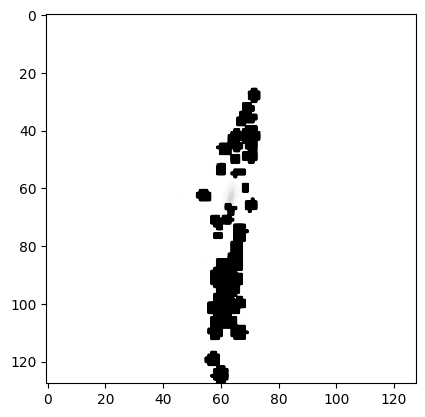

In [98]:
pr = np.load('../data/TNGgalaxies/114388/SDSS_G_d_10.0_theta_1.57_raw.npy')
plt.imshow(np.log(pr), cmap = 'Grays', vmin = 1e-23,vmax = 10)

In [92]:
from pts.visual.rgbimage import RGBImage
import astropy.units as u

In [105]:
pr_ast = np.stack((pr, pr, pr), axis=-1)

In [106]:
#pr = np.load('../data/TNGgalaxies/114388/HIMom1_d_10.0_theta_0.00.npy')
pr_ast = pr_ast * u.Unit('MJy/sr')

In [108]:
image = RGBImage(pr_ast.value)
fmin = 1e-5 * u.MJy/u.sr
fmax = 1e3 * u.MJy/u.sr
image.setRange(fmin.value, fmax.value)
image.applyLog()     # Aplicar transformación logarítmica
image.applyCurve()   # Aplicar curva de color
image.saveTo('../data/TNGgalaxies/114388/pr.png')

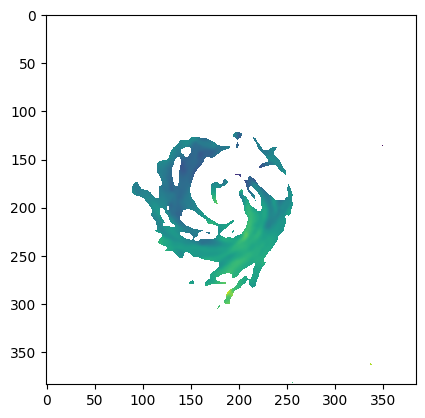

In [69]:
pr = np.load('../data/TNGgalaxies/114388/HIMom1_d_10.0_theta_0.00.npy')
plt.imshow(pr*mask)